# Download and unzip movies review data

In [1]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
!tar xzf review_polarity.tar.gz

--2021-02-15 10:53:45--  http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3127238 (3.0M) [application/x-gzip]
Saving to: ‘review_polarity.tar.gz’

review_polarity.tar 100%[===================>]   2.98M  11.3MB/s    in 0.3s    

2021-02-15 10:53:45 (11.3 MB/s) - ‘review_polarity.tar.gz’ saved [3127238/3127238]



# Import libraries and load movies review data

In [2]:
import re
import nltk
from pprint import pprint
from nltk.corpus import stopwords
import pandas as pd
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
movies = load_files("txt_sentoken", encoding="utf-8")
print(movies)
X, y = movies.data, movies.target
nltk.download('wordnet')
nltk.download('stopwords')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Data Preprocessing

In [3]:
stemmer = WordNetLemmatizer()
docs = []
for sen in range(0, len(X)): 
  document = re.sub('\s+[\\n\\r]+', '', X[sen])
  document = re.sub('\W', ' ', document)
  document = re.sub('\s+[a-zA-Z]\s+', ' ', document)

  document = document.lower()
  document = document.split()
  document = [stemmer.lemmatize(word) for word in document]
  document = ' '.join(document)

  docs.append(document)

print(len(docs))

2000


# Split dataset into train(70%) and validation (30%) for curves

In [4]:
 X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(docs, y, test_size=0.3, random_state=1) # for random search

# Split dataset into train (70%), validation (20%) and test (10%)

In [5]:
 X_train, X_test, y_train, y_test = train_test_split(docs, y, test_size=0.3, random_state=1)
 X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.333, random_state=1)

In [6]:
print(len(X_train),len(y_train))
print(len(X_test),len(y_test))
print(len(X_val),len(y_val))

1400 1400
200 200
400 400


# Feature extraction (Tf*IDF n-gram features)

In [7]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000,sublinear_tf=True, stop_words=stopwords.words('english'))

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

print(vectorizer.get_feature_names())

['000', '10', '10 scale', '100', '11', '12', '13', '13th', '14', '15', '16', '17', '18', '1960', '1960s', '1970s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '20', '20 minute', '200', '2000', '2001', '30', '40', '50', '54', '60', '70', '80', '8mm', '90', '90 minute', '_the', 'abandon', 'abandoned', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abyss', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'accepts', 'accident', 'accidentally', 'acclaimed', 'accompanied', 'accomplish', 'accomplished', 'accomplishment', 'according', 'account', 'accurate', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'act like', 'acted', 'acting', 'action', 'action film', 'action flick', 'action hero', 'action movie', 'action scene', 'action sequence', 'action thriller', 'activity', 'actor', 'actor film', 'actress', 'actual', 'actually', 'ad', 'adam', 'adaptation', 'adapted', 'add', 'added', 

# Linear Classifiers

## Baseline with Precision,  recall and F1  scores 

In [8]:
base = DummyClassifier(strategy='most_frequent')
base.fit(X_train_tfidf, y_train)

predictions = base.predict(X_train_tfidf)
predictions_val = base.predict(X_val_tfidf)
predictions_test = base.predict(X_test_tfidf)

print('--------------Train set------------------------------------')
print(classification_report(y_train,predictions,digits=5))
print('--------------Validation set-------------------------------')
print(classification_report(y_val,predictions_val,digits=5))
print('--------------Test set-------------------------------------')
print(classification_report(y_test,predictions_test,digits=5))

--------------Train set------------------------------------
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       692
           1    0.50571   1.00000   0.67173       708

    accuracy                        0.50571      1400
   macro avg    0.25286   0.50000   0.33586      1400
weighted avg    0.25575   0.50571   0.33970      1400

--------------Validation set-------------------------------
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000       209
           1    0.47750   1.00000   0.64636       191

    accuracy                        0.47750       400
   macro avg    0.23875   0.50000   0.32318       400
weighted avg    0.22801   0.47750   0.30864       400

--------------Test set-------------------------------------
              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        99
           1    0.50500   1.00000   0.67110       101

  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic Regression with Precision,  recall and F1  scores

In [9]:
clf = LogisticRegression(solver="liblinear",C=0.9)
clf.fit(X_train_tfidf, y_train)

predictions = clf.predict(X_train_tfidf)
predictions_val = clf.predict(X_val_tfidf)
predictions_test = clf.predict(X_test_tfidf)

print('--------------Train set------------------------------------')
print(classification_report(y_train,predictions,digits=4))
print('--------------Validation set-------------------------------')
print(classification_report(y_val,predictions_val,digits=4))
print('--------------Test set-------------------------------------')
print(classification_report(y_test,predictions_test,digits=4))

--------------Train set------------------------------------
              precision    recall  f1-score   support

           0     0.9725    0.9697    0.9711       692
           1     0.9704    0.9732    0.9718       708

    accuracy                         0.9714      1400
   macro avg     0.9714    0.9714    0.9714      1400
weighted avg     0.9714    0.9714    0.9714      1400

--------------Validation set-------------------------------
              precision    recall  f1-score   support

           0     0.8768    0.8852    0.8810       209
           1     0.8730    0.8639    0.8684       191

    accuracy                         0.8750       400
   macro avg     0.8749    0.8745    0.8747       400
weighted avg     0.8750    0.8750    0.8750       400

--------------Test set-------------------------------------
              precision    recall  f1-score   support

           0     0.8947    0.8586    0.8763        99
           1     0.8667    0.9010    0.8835       101

  

# Bootstrap statistical significance

In [10]:
predictions = clf.predict(X_train_tfidf)
score_train = f1_score(y_train,predictions,average='macro')
print("train f1-score: %.2f%%"%(score_train*100))

train f1-score: 97.14%


In [11]:
from sklearn.utils import resample
import numpy as np

def BootStrap(test_set=X_test_tfidf,y_test=y_test,b=20):

  predictions_log = clf.predict(test_set)
  predictions_base = base.predict(test_set)
  
  f1_score_log = f1_score(y_test,predictions_log,average='macro')
  f1_score_base = f1_score(y_test,predictions_base,average='macro')

  delta = f1_score_log-f1_score_base
  s=0
  for _ in range(b):
    X_test_sample, y_test_sample = resample(test_set,y_test)

    predictions_log_sample = clf.predict(X_test_sample)
    predictions_base_sample = base.predict( X_test_sample)

    f1_score_log_sample = f1_score(y_test_sample,predictions_log_sample,average='macro')
    f1_score_base_sample = f1_score(y_test_sample,predictions_base_sample,average='macro')

    delta_star = f1_score_log_sample - f1_score_base_sample
    if delta_star > 2*delta:
      s+=1

  return round(s/b,4)

In [12]:
pvalue=BootStrap()
print(pvalue)

0.0


# Learning Curves

##Dataset for Learning Curves split into test and train

In [13]:
X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(docs, y, test_size=0.3, random_state=1)
X_train_tfidf_lc = vectorizer.fit_transform(X_train_lc)
X_test_tfidf_lc = vectorizer.transform(X_test_lc)

print(len(X_train_lc),len(y_train_lc))
print(len(X_test_lc),len(y_test_lc))

print(vectorizer.get_feature_names())

1400 1400
600 600
['000', '10', '10 scale', '100', '11', '12', '13', '13th', '14', '15', '16', '17', '18', '1960', '1960s', '1970s', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '20', '20 minute', '200', '2000', '2001', '30', '40', '50', '54', '60', '70', '80', '8mm', '90', '90 minute', '_the', 'abandon', 'abandoned', 'ability', 'able', 'abraham', 'absence', 'absent', 'absolute', 'absolutely', 'absurd', 'abuse', 'abyss', 'academy', 'academy award', 'accent', 'accept', 'acceptable', 'accepts', 'accident', 'accidentally', 'acclaimed', 'accompanied', 'accomplish', 'accomplished', 'accomplishment', 'according', 'account', 'accurate', 'accused', 'ace', 'achieve', 'achieved', 'achievement', 'acid', 'across', 'act', 'act like', 'acted', 'acting', 'action', 'action film', 'action flick', 'action hero', 'action movie', 'action scene', 'action sequence', 'action thriller', 'activity', 'actor', 'actor film', 'actress', 'actual', 'actually', 'ad', 'adam', 'adaptation', 'adapted'

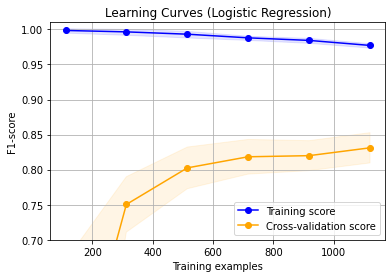

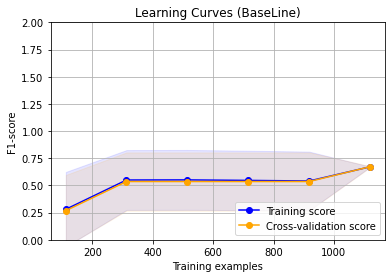

In [14]:
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 6)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,scoring='f1', train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
  
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")

    plt.legend(loc="lower right")
    return plt

X, y = X_train_tfidf_lc,y_train_lc

title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = LogisticRegression(solver="liblinear",C=0.9)
plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=-1)
plt.show()

title = "Learning Curves (BaseLine)"
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = DummyClassifier(strategy='most_frequent')
plot_learning_curve(estimator, title, X, y, (0, 2), cv=cv, n_jobs=-1)
plt.show()

In [15]:
import sklearn.metrics as metric
metric.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

##Precision-Recall curves

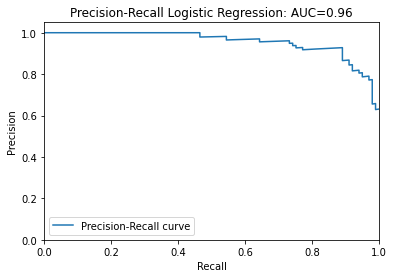

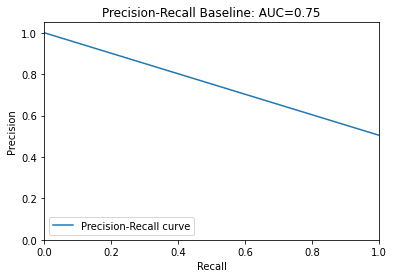

In [16]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
estimators = {'Logistic Regression':LogisticRegression(solver="liblinear",C=0.9),
              'Baseline':DummyClassifier(strategy='most_frequent')
              }

for (name,estimator) in estimators.items():
  model =estimator
  model.fit(X_train_tfidf,y_train)
  pred = model.predict_proba(X_test_tfidf)
  precision, recall, thresholds = precision_recall_curve(y_test, pred[:,1])
  area = auc(recall, precision)
  plt.plot(recall, precision, label='Precision-Recall curve')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall %s: AUC=%0.2f' % (name,area))
  plt.legend(loc="lower left")
  plt.show()

# Hyper-parameter tuning via random search

In [17]:
lr_pipeline = Pipeline([
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('lr', LogisticRegression())])

grid_params = {
  'lr__solver': ['liblinear'],
  'lr__C': np.linspace(0.1, 1, 10),
  'lr__max_iter': [50, 100, 200],
  'tfidf_vectorizer__min_df': np.linspace(0.01, 0.1, 10),
  'tfidf_vectorizer__ngram_range': [(1,1),(1,2),(1,3)],  
  'tfidf_vectorizer__sublinear_tf': [True,False],
  
}
clf2 = RandomizedSearchCV(lr_pipeline, grid_params,scoring='f1',cv=3,n_jobs=-1, n_iter=100)
clf2.fit(X_train_rs, y_train_rs)
print("Best Score: ", clf2.best_score_)
print("Best Params: ", clf2.best_params_)

Best Score:  0.8526074435967628
Best Params:  {'tfidf_vectorizer__sublinear_tf': True, 'tfidf_vectorizer__ngram_range': (1, 3), 'tfidf_vectorizer__min_df': 0.01, 'lr__solver': 'liblinear', 'lr__max_iter': 100, 'lr__C': 0.7000000000000001}
